# Preprocessing

**Imports**

The dataset was uploaded to Google Drive. This way seemed better for avoiding extra work with files.
https://www.kaggle.com/datasets/andrewmvd/steam-reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports
import re
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt      # for visualisation

from textblob import TextBlob      # for sentiment analysis

import spacy      # for tokenization, lemmatization and stopwords
from spacy.lang.en import English
nlp = English()

import nltk     # for collocations
from nltk.collocations import *

from wordcloud import WordCloud     #for word cloud

import seaborn as sns     # for charts customization

from sklearn.feature_extraction.text import CountVectorizer     # for bag-of-words

**Pandas Basics**

The original dataset size is more than 2 GB. To speed up all the processes it was decided to make a smaller dataset, so I chose 100 games and 100 reviews to each game.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python/dataset.csv')     # full dataset
df.dropna(inplace=True) # remove empty cells

In [ ]:
# optimise and reduce the original dataset to 100 feedbacks for 100 games

df.drop(['review_votes'], axis=1, inplace=True)         # remove unnecessary columns
new_df = df.groupby('app_id').head(100).reset_index(drop=True)

uniq_id = pd.unique(new_df['app_id'])
final_df = new_df.loc[new_df['app_id'].isin(uniq_id[0:100])]
print(final_df)

      app_id                      app_name  \
0         10                Counter-Strike   
1         10                Counter-Strike   
2         10                Counter-Strike   
3         10                Counter-Strike   
4         10                Counter-Strike   
...      ...                           ...   
8269  115200  Cossacks II: Napoleonic Wars   
8270  115200  Cossacks II: Napoleonic Wars   
8271  115200  Cossacks II: Napoleonic Wars   
8272  115200  Cossacks II: Napoleonic Wars   
8273  115200  Cossacks II: Napoleonic Wars   

                                            review_text  review_score  
0                                       Ruined my life.             1  
1     This will be more of a ''my experience with th...             1  
2                         This game saved my virginity.             1  
3     • Do you like original games? • Do you like ga...             1  
4              Easy to learn, hard to master.                       1  
...            

**Lemmatization**

In [ ]:
# lemmatization with spacy
# spacy tokenizes text, so there's no need for any special tokenization functions

nlp = spacy.load("en_core_web_sm")
lemma_text_list = []
for doc in nlp.pipe(final_df["review_text"], batch_size=32, n_process=3, disable=["parser", "ner"]):
  re_compile = re.compile('^[a-zA-Z]*\Z')
  lemma_text_list.append(" ".join(token.lemma_ for token in doc if not token.is_stop and re_compile.search(token.text) is not None).lower())
final_df["lemmas"] = lemma_text_list

<ipython-input-10-662c39560163>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["lemmas"] = lemma_text_list


In [ ]:
final_df.head(10)

,app_id,app_name,review_text,review_score,lemmas
0,10,Counter-Strike,Ruined my life.,1,ruin life
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,experience game type review say thing like gre...
2,10,Counter-Strike,This game saved my virginity.,1,game save virginity
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,like original game like game lag like game run...
4,10,Counter-Strike,"Easy to learn, hard to master.",1,easy learn hard master
5,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,revolver play
6,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,well duty ghost
7,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben ...",1,not buy skin case key sticker gaben not steal ...
8,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,counter strike ok year unlimited fun friend fi...
9,10,Counter-Strike,Every server is spanish or french. I can now f...,1,server spanish french fluently swear language


# Frequency

Now we have lemmas. Let's find the most common collocations using Counter and NLTK. Though most common lemmas will be defined later, I left the Counter for lemmas in this section for better code readability.

In [ ]:
# create Counter
# it will come in handy later, after sentiment analysis
def get_freq(series):
  return Counter([lemma for row in series for lemma in row.split()])

**Collocations**

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [ ]:
# find collocations
def collocations(lemmas):
  tokens = nltk.wordpunct_tokenize(lemmas)
  finder = BigramCollocationFinder.from_words(tokens)
  scored = finder.score_ngrams(bigram_measures.raw_freq)
  res = sorted(bigram for bigram, score in scored)
  return res

In [ ]:
final_df['collocations'] = final_df['lemmas'].apply(collocations)
final_df.head(10)

<ipython-input-15-595230fcb37b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['collocations'] = final_df['lemmas'].apply(collocations)


,app_id,app_name,review_text,review_score,lemmas,collocations
0,10,Counter-Strike,Ruined my life.,1,ruin life,"[(ruin, life)]"
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,experience game type review say thing like gre...,"[(account, lose), (advanced, way), (ago, think..."
2,10,Counter-Strike,This game saved my virginity.,1,game save virginity,"[(game, save), (save, virginity)]"
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,like original game like game lag like game run...,"[(child, sleep), (end, pc), (game, lag), (game..."
4,10,Counter-Strike,"Easy to learn, hard to master.",1,easy learn hard master,"[(easy, learn), (hard, master), (learn, hard)]"
5,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,revolver play,"[(revolver, play)]"
6,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,well duty ghost,"[(duty, ghost), (well, duty)]"
7,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben ...",1,not buy skin case key sticker gaben not steal ...,"[(buy, skin), (case, key), (gaben, not), (key,..."
8,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,counter strike ok year unlimited fun friend fi...,"[(addicting, game), (amp, hf), (cheep, fun), (..."
9,10,Counter-Strike,Every server is spanish or french. I can now f...,1,server spanish french fluently swear language,"[(fluently, swear), (french, fluently), (serve..."


In [ ]:
# count the most frequent collocations
def get_freq_colloc(collocations):
  collocations_list = []
  for collocation in collocations:
    for row in collocation:
      collocations_list.append(row)
  return Counter(collocations_list)

In [ ]:
collocation_freq = get_freq_colloc(final_df['collocations'])
collocation_freq.most_common(20)

[(('play', 'game'), 628),
 (('game', 'play'), 553),
 (('good', 'game'), 450),
 (('game', 'like'), 365),
 (('great', 'game'), 327),
 (('feel', 'like'), 315),
 (('buy', 'game'), 304),
 (('recommend', 'game'), 297),
 (('game', 'good'), 284),
 (('fun', 'game'), 265),
 (('like', 'game'), 251),
 (('puzzle', 'game'), 228),
 (('game', 'game'), 217),
 (('game', 'great'), 203),
 (('game', 'fun'), 200),
 (('adventure', 'game'), 196),
 (('love', 'game'), 183),
 (('voice', 'act'), 168),
 (('highly', 'recommend'), 167),
 (('point', 'click'), 167)]

Text(0.5, 1.0, 'The most frequent collocations in all reviews')

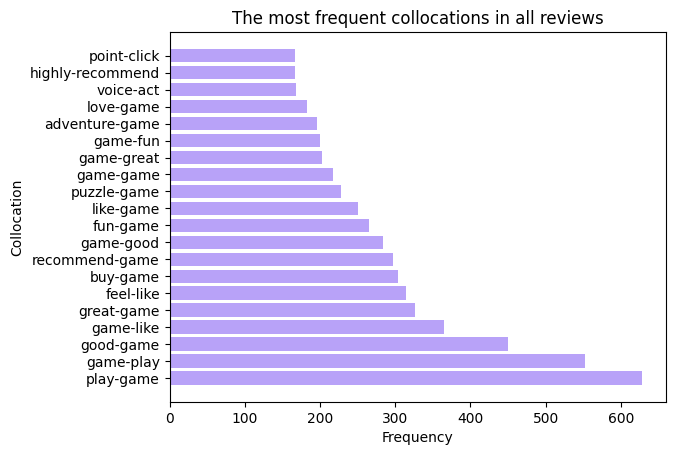

In [ ]:
# visualize 20 most frequent collocations in all reviews
most_freq_colloc = collocation_freq.most_common(20)
x, y = zip(*most_freq_colloc)
words = []
for w1, w2 in x:
  words.append(w1 + '-' + w2)
plt.barh(words, width=y, color='#b8a2f8')
plt.xlabel('Frequency')
plt.ylabel('Collocation')
plt.title('The most frequent collocations in all reviews')

# Sentiment analysis

Here we are interested in:
  sentiment analysis of each review;
  comparison of sentiment scores extracted by our model (below 'by our model') and sentiment scores already presented in the dataset (below 'review_score, by dataset');
  counting a score for each game based on average sent_score calculated for reviews to each game (mean_sent).

Neutral reviews are left out of sight as they don't have any weight.

**Sentiment analysis of each review**

In [ ]:
# create a function to apply sentiment analysis to each review text
def sentiment_analysis(target_text):
    blob = TextBlob(target_text)
    sentiment_score = blob.sentiment.polarity
    return round(sentiment_score, 3)

In [ ]:
# sentiment analysis for each review text, output
final_df['sentiment_score'] = final_df['lemmas'].apply(sentiment_analysis)
final_df.head(10)

<ipython-input-20-eec7c4f7eeae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['sentiment_score'] = final_df['lemmas'].apply(sentiment_analysis)


,app_id,app_name,review_text,review_score,lemmas,collocations,sentiment_score
0,10,Counter-Strike,Ruined my life.,1,ruin life,"[(ruin, life)]",0.000
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,experience game type review say thing like gre...,"[(account, lose), (advanced, way), (ago, think...",0.016
2,10,Counter-Strike,This game saved my virginity.,1,game save virginity,"[(game, save), (save, virginity)]",-0.400
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,like original game like game lag like game run...,"[(child, sleep), (end, pc), (game, lag), (game...",-0.204
4,10,Counter-Strike,"Easy to learn, hard to master.",1,easy learn hard master,"[(easy, learn), (hard, master), (learn, hard)]",0.071
5,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,revolver play,"[(revolver, play)]",0.000
6,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,well duty ghost,"[(duty, ghost), (well, duty)]",0.000
7,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben ...",1,not buy skin case key sticker gaben not steal ...,"[(buy, skin), (case, key), (gaben, not), (key,...",0.000
8,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,counter strike ok year unlimited fun friend fi...,"[(addicting, game), (amp, hf), (cheep, fun), (...",0.111
9,10,Counter-Strike,Every server is spanish or french. I can now f...,1,server spanish french fluently swear language,"[(fluently, swear), (french, fluently), (serve...",0.000


**Comparison of scores by dataset and by our model**

Text(0.5, 1.0, 'Positive and Negative Reviews Distribution by Dataset')

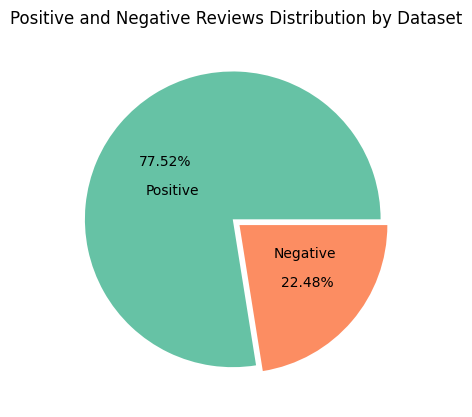

In [ ]:
# pie chart of pos/neg reviews according to scores from the dataset
plt.pie(final_df['review_score'].value_counts(),labels=['Positive','Negative'],autopct='%0.2f%%',colors=sns.color_palette('Set2'), textprops={"fontsize":10},
        explode=[0.03, 0.03], labeldistance=0.3)

plt.title(label="Positive and Negative Reviews Distribution by Dataset", fontdict={"fontsize":12}, pad=10)

In [ ]:
# create function to convert our sentiment scores so that they fitted to the model of scores by the dataset (review_score)
def convert_sent_score(sentiment_score):
  if sentiment_score == 0:
    return 0
  elif sentiment_score > 0:
    return 1
  else:
    return -1

In [ ]:
# sentiment score comparison results
comparison_series = final_df['sentiment_score'].apply(convert_sent_score)
comparison_series.head(10)

0    0
1    1
2   -1
3   -1
4    1
5    0
6    0
7    0
8    1
9    0
Name: sentiment_score, dtype: int64

Text(0.5, 1.0, 'Positive and Negative Reviews Distribution by our Model')

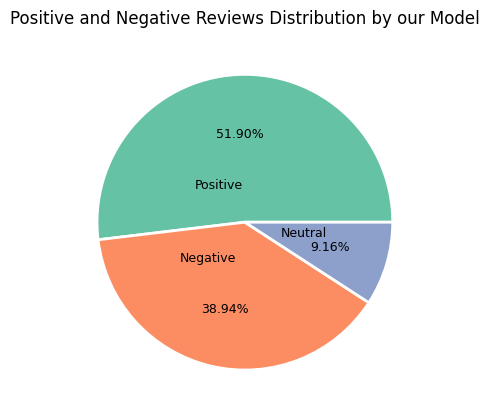

In [ ]:
# create a pie chart of pos/neg reviews according to scores extracted by our model
wp = {'linewidth': 2, 'edgecolor':'white'}
plt.pie(comparison_series.value_counts(),labels=['Positive','Negative','Neutral'],autopct='%0.2f%%',colors=sns.color_palette('Set2'), textprops={"fontsize":9},
         labeldistance=0.25, wedgeprops=wp)

plt.title(label="Positive and Negative Reviews Distribution by our Model", fontdict={"fontsize":12}, pad=10)

**Mean_sent for each game**

In [ ]:
# average sentiment score for each game
average_sent = final_df.groupby(['app_name']).agg(mean_sent = ('sentiment_score', 'mean')).reset_index()

In [ ]:
# create dataframe with positively evaluated games, contains app_name + mean_sent
positive = average_sent[average_sent['mean_sent'] > 0]

# choose 10 games with the highest mean_sent
sorted_pos = positive.sort_values(by='mean_sent', ascending=False).head(10).reset_index(drop=True)
sorted_pos

,app_name,mean_sent
0,Portal 2 - The Final Hours,0.240090
1,Silo 2,0.211394
2,Waves,0.142290
3,Stacking,0.140540
4,Call of Duty: Modern Warfare 2,0.128490
5,Call of Duty: World at War,0.127760
6,Bastion,0.117120
7,Shadowgrounds: Survivor,0.107220
8,BEEP,0.106270
9,Project Zomboid,0.100000


Text(0, 0.5, 'Sentiment score')

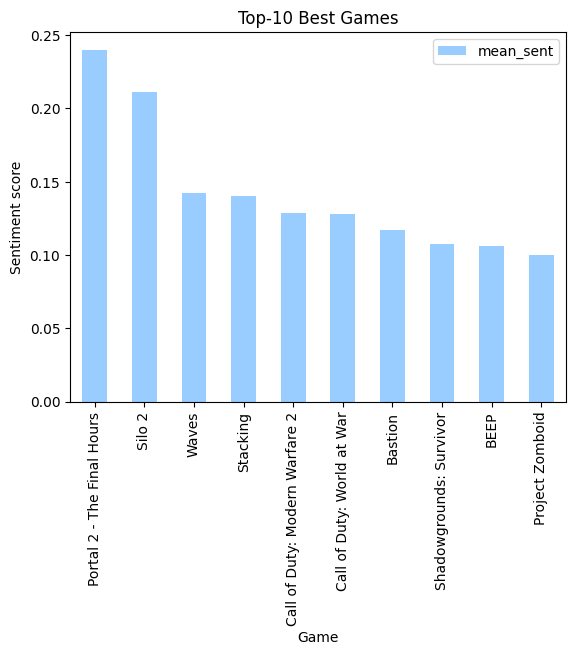

In [ ]:
# bar chart for top-10 best games

chart_pos = sorted_pos.plot.bar(x='app_name', y='mean_sent', color='#99CCFF', title='Top-10 Best Games')
chart_pos.set_xlabel('Game')
chart_pos.set_ylabel('Sentiment score')

In [ ]:
# create dataframe with negatively evaluated games, contains app_name + mean_sent
negative = average_sent[average_sent['mean_sent'] < 0]

# choose 10 games with the lowest mean_sent
sorted_neg = negative.sort_values(by='mean_sent', ascending=True).head(10).reset_index(drop=True)
sorted_neg

,app_name,mean_sent
0,Dead Mountaineer's Hotel,-0.172982
1,PT Boats: Knights of the Sea,-0.144143
2,Sherlock Holmes: The Mystery of The Mummy,-0.127400
3,PT Boats: South Gambit,-0.127167
4,Guardians of Middle-earth,-0.125280
5,Sherlock Holmes: The Mystery of The Persian Ca...,-0.105643
6,Postal 3,-0.102670
7,Inside a Star-filled Sky,-0.086610
8,Fowl Space,-0.085960
9,Bunch Of Heroes,-0.073310


Text(0, 0.5, 'Sentiment score')

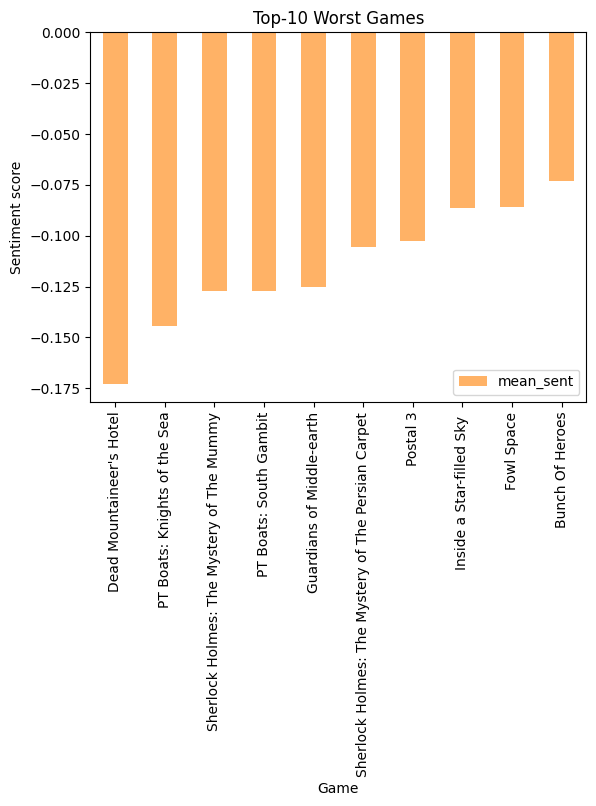

In [ ]:
# bar chart for top-10 worst games

chart_neg = sorted_neg.plot.bar(x='app_name', y='mean_sent', color='#FFB266', title='Top-10 Worst Games')
chart_neg.set_xlabel('Game')
chart_neg.set_ylabel('Sentiment score')

**Sent_score distribution**

Text(0.5, 0.98, 'Positive and negative sent_score distribution')

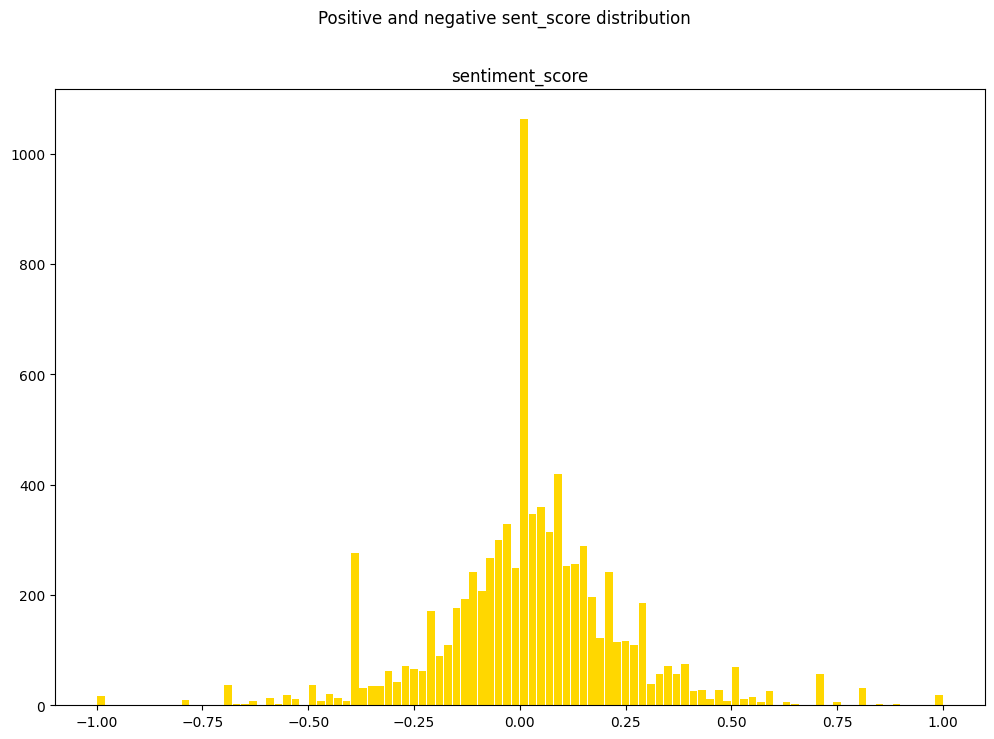

In [ ]:
# sentiment distribution
sent_dist_graph = final_df.hist(column='sentiment_score', bins=100, grid=False, figsize=(12,8), color='#FFD700', zorder=2, rwidth=0.9)
plt.suptitle("Positive and negative sent_score distribution")

# Freq + sent

Let's mix what we got from work with most common words and sentiment analysis.

In [ ]:
# create a dataframe with positive reviews
positive_df = final_df.loc[final_df['sentiment_score'] > 0].reset_index(drop=True)
positive_df.head(10)

,app_id,app_name,review_text,review_score,lemmas,collocations,sentiment_score
0,10,Counter-Strike,This will be more of a ''my experience with th...,1,experience game type review say thing like gre...,"[(account, lose), (advanced, way), (ago, think...",0.016
1,10,Counter-Strike,"Easy to learn, hard to master.",1,easy learn hard master,"[(easy, learn), (hard, master), (learn, hard)]",0.071
2,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,counter strike ok year unlimited fun friend fi...,"[(addicting, game), (amp, hf), (cheep, fun), (...",0.111
3,10,Counter-Strike,CS is one of the greatest and undermined games...,1,cs great undermined game history opinion good ...,"[(ability, instead), (accomplish, goal), (acid...",0.199
4,10,Counter-Strike,Best shooter for 10 years. Steam evolved becau...,1,good shooter year steam evolve game,"[(evolve, game), (good, shooter), (shooter, ye...",0.150
5,10,Counter-Strike,"One of the best FPS Games, the 1.6 Version wil...",1,good fps games version stay heart recommend vo...,"[(action, shooter), (fps, games), (games, vers...",0.400
6,10,Counter-Strike,Best game ever! Started my gaming addiction :D,1,good game start gaming addiction,"[(game, start), (gaming, addiction), (good, ga...",0.150
7,10,Counter-Strike,Probably the best FPS shooter ever made. Nothi...,1,probably good fps shooter beat counter strike,"[(beat, counter), (counter, strike), (fps, sho...",0.700
8,10,Counter-Strike,Update to my review with some shameless adve...,1,update review shameless advertising hey reader...,"[(account, originally), (address, review), (ad...",0.119
9,10,Counter-Strike,"Well, look at my hours played you can already ...",1,look hour play tell good game yes,"[(game, yes), (good, game), (hour, play), (loo...",0.150


In [ ]:
# create a dataframe with negative reviews
negative_df = final_df.loc[final_df['sentiment_score'] < 0].reset_index(drop=True)
negative_df.head(10)

,app_id,app_name,review_text,review_score,lemmas,collocations,sentiment_score
0,10,Counter-Strike,This game saved my virginity.,1,game save virginity,"[(game, save), (save, virginity)]",-0.400
1,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,like original game like game lag like game run...,"[(child, sleep), (end, pc), (game, lag), (game...",-0.204
2,10,Counter-Strike,"WARNING : DO NOT buy this game, if you do, you...",1,warning buy game sunlight,"[(buy, game), (game, sunlight), (warning, buy)]",-0.400
3,10,Counter-Strike,Many players learned here what do wellknown te...,1,player learn wellknown term like lag noob rage...,"[(lag, noob), (learn, wellknown), (like, lag),...",-0.106
4,10,Counter-Strike,Playing it since 2010. Still bad at it. 10/1...,1,play bad good game cs series,"[(bad, good), (cs, series), (game, cs), (good,...",-0.133
5,10,Counter-Strike,This game is the best game forever &lt;3,1,game good game forever,"[(game, forever), (game, good), (good, game)]",-0.033
6,10,Counter-Strike,Blame this game for the rise of the online mul...,1,blame game rise online multiplayer modern mili...,"[(blame, game), (change, think), (community, c...",-0.021
7,10,Counter-Strike,2006 4:3 800x600 Resolution Windows XP 2001 o...,1,resolution window xp office computer fully whi...,"[(character, white), (computer, fully), (cs, d...",-0.057
8,10,Counter-Strike,Playing this game since 2001. It ruined my lif...,1,play game ruin life star,"[(game, ruin), (life, star), (play, game), (ru...",-0.400
9,10,Counter-Strike,First of all its my first online game ever. I ...,1,online game young play friend lan match fun be...,"[(aim, enemy), (bad, moment), (bet, loser), (b...",-0.144


**Positive reviews**

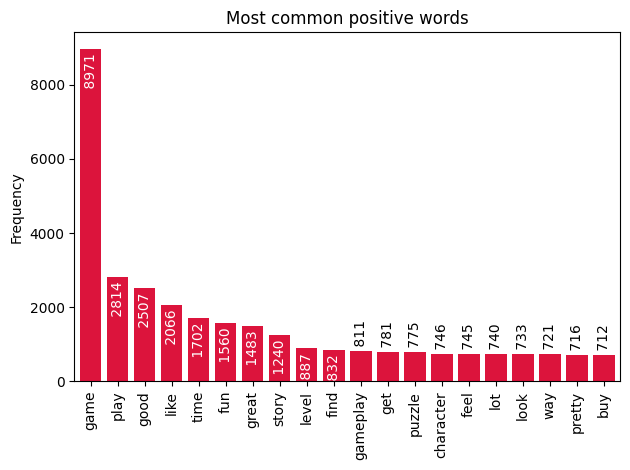

In [ ]:
# build a graph with most frequent words in positive reviews
positive_freq = get_freq(positive_df['lemmas'])
y = [count for tag, count in positive_freq.most_common(20)]
x = [tag for tag, count in positive_freq.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Most common positive words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(positive_freq.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

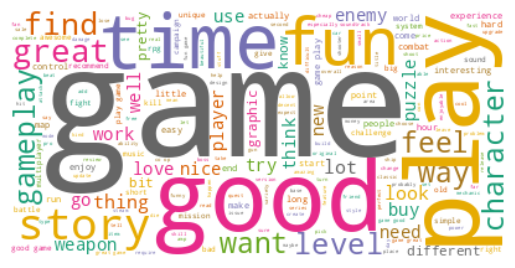

In [ ]:
# word cloud for positive reviews
def get_all_lemas_like_string(series):
  return ' '.join([lemma for row in series for lemma in row.split()])

wordcloud = WordCloud(background_color='white', colormap='Dark2').generate(get_all_lemas_like_string(positive_df['lemmas']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# collocations in positive reviews
collocation_freq_pos = get_freq_colloc(positive_df['collocations'])
collocation_freq_pos.most_common(20)

[(('good', 'game'), 292),
 (('game', 'play'), 285),
 (('play', 'game'), 254),
 (('great', 'game'), 247),
 (('game', 'good'), 198),
 (('game', 'like'), 178),
 (('feel', 'like'), 156),
 (('game', 'great'), 139),
 (('recommend', 'game'), 135),
 (('fun', 'game'), 132),
 (('love', 'game'), 124),
 (('highly', 'recommend'), 119),
 (('puzzle', 'game'), 117),
 (('co', 'op'), 109),
 (('early', 'access'), 105),
 (('buy', 'game'), 104),
 (('game', 'fun'), 104),
 (('game', 'worth'), 102),
 (('adventure', 'game'), 100),
 (('access', 'review'), 100)]

Text(0.5, 1.0, 'The most frequent collocations in positive reviews')

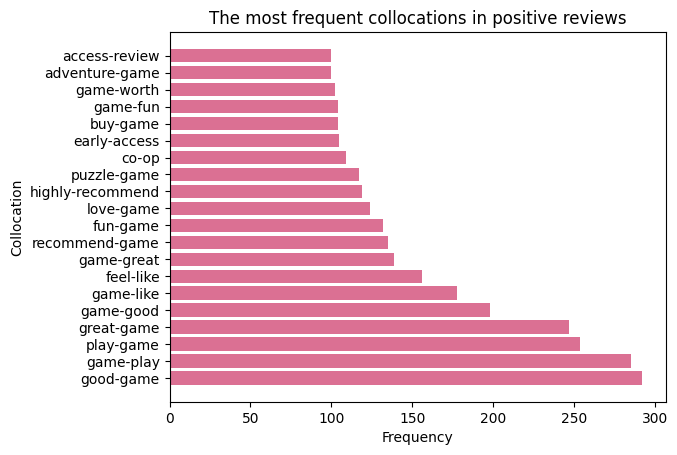

In [ ]:
# visualize the most frequent collocations in positive reviews
most_freq_colloc_pos = collocation_freq_pos.most_common(20)
x, y = zip(*most_freq_colloc_pos)
words = []
for w1, w2 in x:
  words.append(w1 + '-' + w2)
plt.barh(words, width=y, color='palevioletred')
plt.xlabel('Frequency')
plt.ylabel('Collocation')
plt.title('The most frequent collocations in positive reviews')

**Negative reviews**

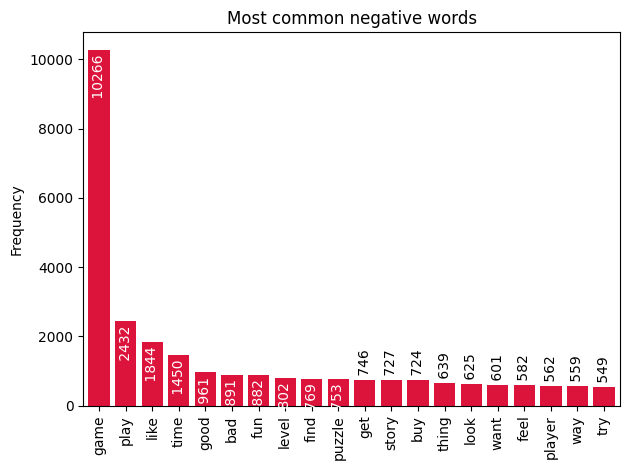

In [ ]:
# build a graph with most frequent words in negative reviews
negative_freq = get_freq(negative_df['lemmas'])
y = [count for tag, count in negative_freq.most_common(20)]
x = [tag for tag, count in negative_freq.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Most common negative words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(negative_freq.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4)
plt.tight_layout()
plt.show()

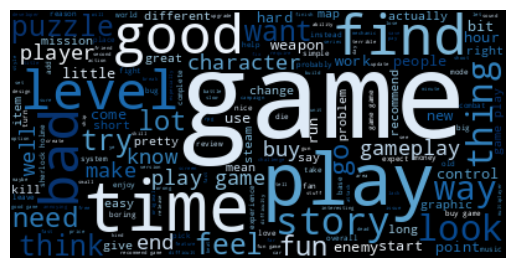

In [ ]:
# word cloud for negative reviews
def get_all_lemas_like_string(series):
  return ' '.join([lemma for row in series for lemma in row.split()])

wordcloud = WordCloud(colormap='Blues').generate(get_all_lemas_like_string(negative_df['lemmas']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# collocations in negative reviews
collocation_freq_neg = get_freq_colloc(negative_df['collocations'])
collocation_freq_neg.most_common(20)

[(('play', 'game'), 367),
 (('game', 'play'), 265),
 (('buy', 'game'), 196),
 (('game', 'like'), 183),
 (('good', 'game'), 158),
 (('recommend', 'game'), 158),
 (('feel', 'like'), 156),
 (('like', 'game'), 148),
 (('game', 'game'), 134),
 (('fun', 'game'), 131),
 (('puzzle', 'game'), 108),
 (('bad', 'game'), 106),
 (('point', 'click'), 98),
 (('voice', 'act'), 97),
 (('adventure', 'game'), 96),
 (('voice', 'acting'), 96),
 (('game', 'fun'), 94),
 (('sherlock', 'holmes'), 94),
 (('game', 'bad'), 84),
 (('game', 'good'), 83)]

Text(0.5, 1.0, 'The most frequent collocations in negative reviews')

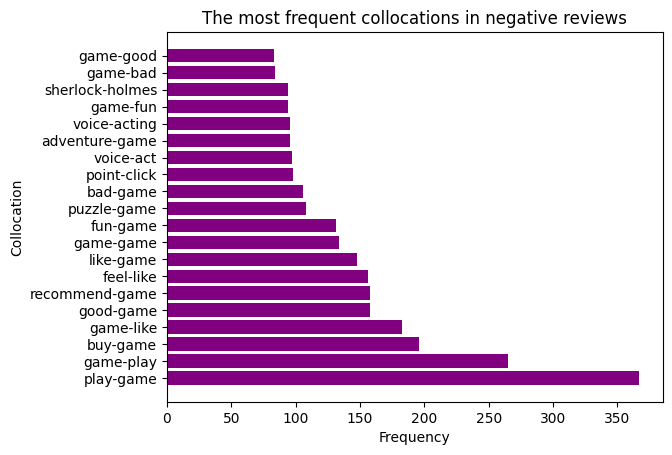

In [ ]:
# visualize the most frequent collocations in positive reviews
most_freq_colloc_neg = collocation_freq_neg.most_common(20)
x, y = zip(*most_freq_colloc_neg)
words = []
for w1, w2 in x:
  words.append(w1 + '-' + w2)
plt.barh(words, width=y, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Collocation')
plt.title('The most frequent collocations in negative reviews')

# Extras

Here I tried to experiment with correlation matrix by defining whether there is any connection between review length (in lemmas) and sentiment score + checked bag-of-words.

**Correlation matrix**

In [ ]:
# count review length in lemmas
lemmas_in_review = final_df['lemmas'].apply(lambda x: len((x.split())))
lemmas_in_review

0         2
1       174
2         3
3        18
4         4
       ... 
8269     22
8270     11
8271     11
8272     76
8273     19
Name: lemmas, Length: 8274, dtype: int64

In [ ]:
# create dataframe for correlation
for_correlation = {'Review length in lemmas': lemmas_in_review,
                   'Sent score': final_df['sentiment_score']}
correlation_df = pd.DataFrame(for_correlation)
correlation_df.head(10)

,Review length in lemmas,Sent score
0,2,0.000
1,174,0.016
2,3,-0.400
3,18,-0.204
4,4,0.071
5,2,0.000
6,3,0.000
7,11,0.000
8,79,0.111
9,6,0.000


<Axes: >

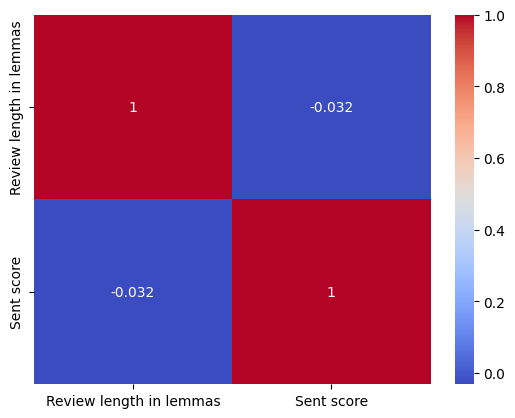

In [ ]:
# form a matrix
correlation_matrix = correlation_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

**Bag-of-words**

In [ ]:
cv = CountVectorizer()
counts = cv.fit_transform(final_df['lemmas'])

df_counts = pd.DataFrame(counts.A, columns=cv.get_feature_names_out())
a = df_counts.iloc[:,100:200]
a.head(100)

,accessoarie,accessory,accident,accidental,accidentally,accidentaly,accidently,acclaim,acclaimed,acclimate,...,activity,actor,actress,actual,actually,actualy,actuate,acutally,acutely,acutually
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
